In [242]:
import numpy as np
import cv2, random, sys
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

np.set_printoptions(threshold=sys.maxsize)

In [243]:
img = cv2.imread('images/test.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert the image to grayscale

small = cv2.imread('images/small.png')
small_gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

imsize = 512
noise = np.random.rand(imsize, imsize)*255

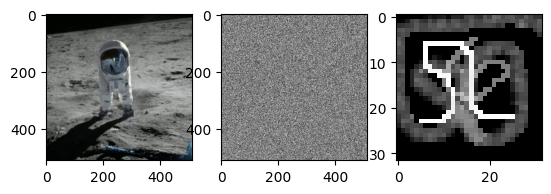

In [244]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(img, cmap='gray')
axs[1].imshow(noise, cmap='gray')
axs[2].imshow(small_gray, cmap='gray')

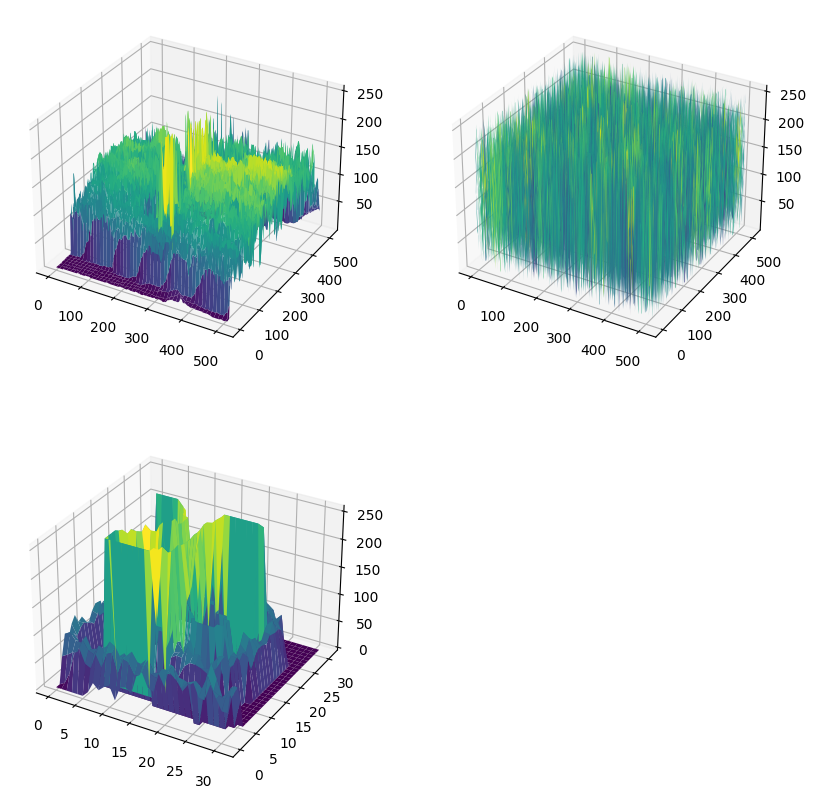

In [245]:
heightmap = plt.figure(figsize=(10, 10))
plt1 = heightmap.add_subplot(221, projection='3d')
plt2 = heightmap.add_subplot(222, projection='3d')
plt3 = heightmap.add_subplot(223, projection='3d')

x1 = y1 = range(imsize)
X1, Y1 = np.meshgrid(x1, y1)  # `plot_surface` expects `x` and `y` data to be 2D

x2 = y2 = range(small.shape[0])
X2, Y2 = np.meshgrid(x2, y2)

plt1.plot_surface(X1, Y1, gray, cmap="viridis")
plt2.plot_surface(X1, Y1, noise, cmap="viridis")
plt3.plot_surface(X2, Y2, small_gray, cmap="viridis")

plt.show()

In [246]:
def apply_filter(kernel, image, x, y):
    # neighbourhood is of size (2a+1)x(2b+1)
    a = (kernel.shape[0] - 1) // 2
    b = (kernel.shape[1] - 1) // 2
    size = image.shape[0]
    sum = 0
    for i in range(-a, a+1, 1):
        for j in range(-b, b+1, 1):
            value = image[(x+i) % size][(y+j) % size]
            sum += kernel[i][j] * value
    return sum

def linear_filter(kernel, image):
    filtered = np.copy(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            filtered[x][y] = apply_filter(kernel, image, x, y)
    return filtered

In [ ]:
n = 5

# identity filter
kernelI = np.zeros((n, n))
kernelI[(n-1)//2][(n-1)//2] = 1

# primitive smoothing filter
kernel_smooth = 1/(n**2) * np.ones((n, n))

# left shift
kernel_Lshift = np.zeros((n, n))
kernel_Lshift[(n-1)//2][0] = 1

# primitive sharpening filter
kernel_sharpen = 2 * kernelI - kernel_smooth

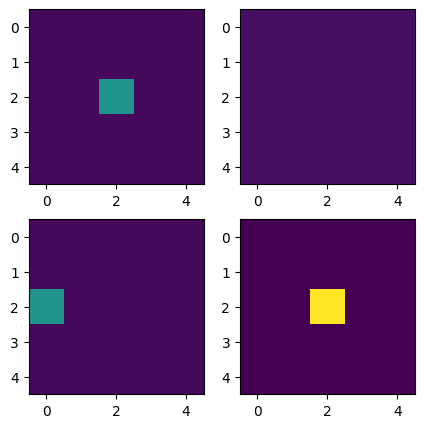

In [256]:

# combine data for all kernels to set a uniform colormap
combined_data = np.array([kernelI, kernel_smooth, kernel_Lshift, kernel_sharpen])
_min, _max = np.amin(combined_data), np.amax(combined_data)

plot_size = 5
fig, axs = plt.subplots(2, 2, figsize=(plot_size, plot_size))

# set cmap bounds to global min and max
axs[0][0].imshow(kernelI, vmin = _min, vmax = _max)
axs[0][1].imshow(kernel_smooth, vmin = _min, vmax = _max)
axs[1][0].imshow(kernel_Lshift, vmin = _min, vmax = _max)
axs[1][1].imshow(kernel_sharpen, vmin = _min, vmax = _max)

In [247]:
input = gray
identity = linear_filter(kernelI, input)
smooth = linear_filter(kernel_smooth, input)
shifted = linear_filter(kernel_Lshift, input)
sharpened = linear_filter(kernel_sharpen, input)

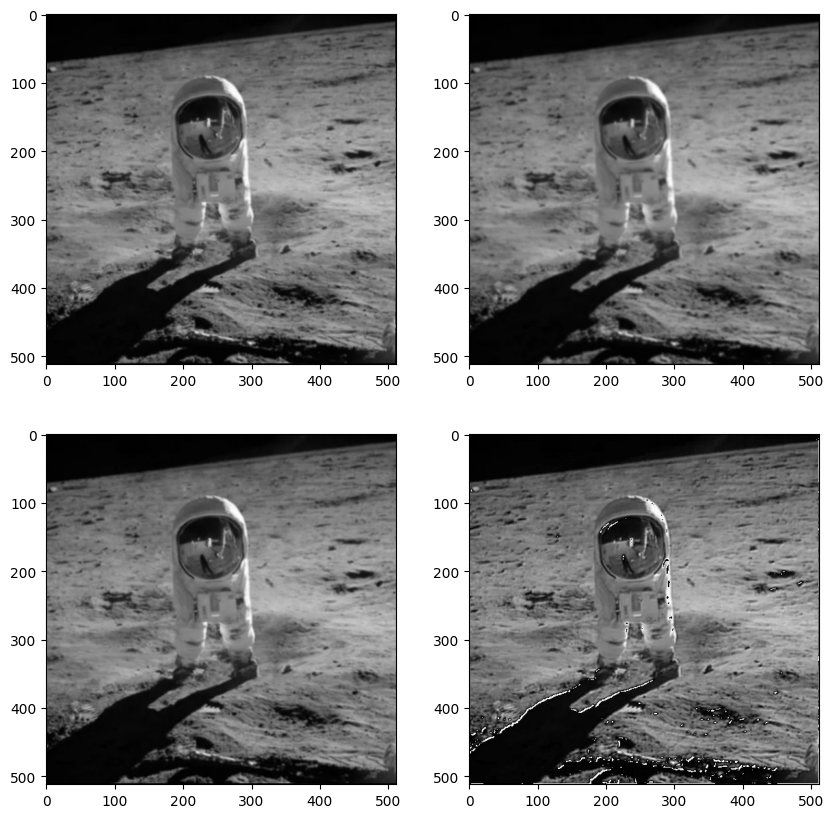

In [248]:
plot_size = 10
fig, axs = plt.subplots(2, 2, figsize=(plot_size, plot_size))
axs[0][0].imshow(identity, cmap='gray')
axs[0][1].imshow(smooth, cmap='gray')
axs[1][0].imshow(shifted, cmap='gray')
axs[1][1].imshow(sharpened, cmap='gray')

plt.show()
